# Demo of bayes_logistic

The package bayeslogistic implements Bayesian logistic regression using a Laplace (Gaussian) approximation for the posterior distribution of the fitted parameters.  As such, it is much faster than using MCMC.  It requires numpy and scipy to work.

Briefly, Bayesian logistic regression works by defining a Gaussian prior on the parameter vector $w$ such that $p(w) = \mathcal{N}(w_0, \Sigma_0)$. Crucially, $w_0 \ne 0$ necessarily (non-zero mean) and $\Sigma_0$ is an arbitrary covariance matrix.  Note that if $w_0 =0$ and $\Sigma_0$ was diagonal with identical values, then the problem would reduce to L2 regularized logistic regression. 

Inclusion of this prior imposes a penalization upon the log likelihood of any data $\mathcal{D}$ we observe. One then has to minimize the negative log posterior which is equal to the following objective up to a constant.

$ f(w|\mathcal{D}) = - \sum_{i=1}^N \{ y_i \log(p_i) + (1-y_i)\log(1-p_i) \}   + \frac{1}{2}(w - w_0)^T \Sigma_0^{-1} (w -w_0)$

where $p_i = e^{X w} /(1 + e^{Xw})$ is the standard logistic probability.  This can be minimized by any gradient (Hessian) based solver. Here we use scipy.optimize.minimize

Under the Laplace approximation, the posterior to the parameter vector $w$ is given by a normal distribution $\mathcal{N}(w, H^{-1})$ where $H = \nabla_w^2 f(w|\mathcal{D}) |_{\hat w}$ is the Hessian of the negative penalized log likelihood (log posterior).  

$H$ is the same Hessian function that would be used for a Hessian based optimization (such as Newton-CG) of $f(w|\mathcal{D})$.  Even if we use a gradent based optimization (such as BFGS) we still need to compute the Hessian to evaluate the posterior distribution.  Of course one can use a diagonal approximation to the Hessian (and we allow for this) if there are a large number of parameters.

Using the full (Laplace) posterior of $w$, one can calculate the full posterior predictive e.g. the the probability $p(y|x,\mathcal{D})$ which is a moderated (relaxed towards 0.5) version of $p_i$ (the standard logistic probability).  This takes into account the uncertainty in our estimate of $w$. 


###This tutorial will demonstrate several features of the bayeslogistic module.

1) How to run the code for a single iteration. Specifying a prior.

2) Calculating the moderated (Bayesian) probability of an event

3) Different optimizers, the choice of prior Hessian, and setting bounds

4) Online updating of a logistic regression model

5) Weighting data points

6) Variable selection and sparse models.

###Import the bayes_logistic module and any other modules needed for this demo notebook

In [1]:
# import bayes_logistic
import bayes_logistic as bl

#-------------------------------------------------------------------------------------
# These are imported for use within the notebook. 
# bayeslogistic imports numpy and scipy.optimize automatically
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy as copy
from sklearn import linear_model

###Make some fake data involving sine waves

In [2]:
# Set the number of data points and variables
N1 = 10100
p = 11

# make a 'time' vector for the sine waves
t = np.linspace(0,100,N1)

#------------------------------------------------------------------------------
# Make a Correlated Feature matrix from sine waves of different frequencies
X1 = np.zeros([N1,p])
for _ in np.arange(10):
    X1[:,_] = np.sin(2*np.pi*0.5*_*t)
X1[:,0] = np.ones([N1,])  # bias term
for _ in np.arange(5):
    X1[:,_+6] = (X1[:,_+1] * X1[:,_+6]) # this is where impose the correlation

#------------------------------------------------------------------------------    
# make a parameter vector
w_true = np.random.uniform(-0.5,0.5,p)
w_true[0] = -1 # bias parameter

#------------------------------------------------------------------------------
# make some binary responses
mu = bl.logistic_prob(X1,w_true)
y1 = np.empty([N1])
for _ in np.arange(N1):
    y1[_] = np.random.binomial(1,mu[_])


### 1) Simple Bayesian Fitting

One always needs to pose a prior parameter vector and prior Hessian matrix.  This can be whatever makes sense given prior knowledge. 

Since this is a simulation, we're going to "cheat" and make a prior parameter vector and Hessian matrix using a small sampling of the data.  

We'll also demonstrate how to perform a Bayesian fit for the first time! 

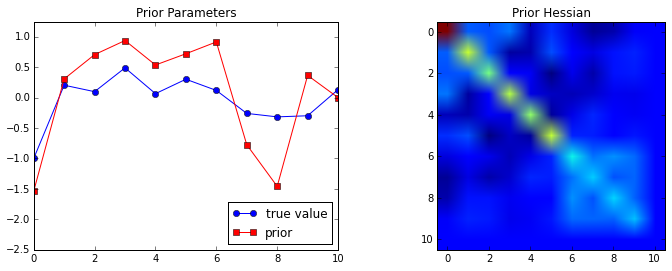

In [3]:
# to get going, set a prior parameter of zeros, and a diagonal hessian 
# corresponding to very low regularization
w_prior = np.zeros(p)
H_prior = np.diag(np.ones(p))*0.001

#----------------------------------------------------------------------------------------
# randomly permute the data
r = np.random.permutation(N1)
X1 = X1[r,:]
y1 = y1[r]
idx = np.arange(100)

#----------------------------------------------------------------------------------------
# Do a bayesian fit with this random sample
# The default uses a full Hessian matrix and a Newton's conjugate gradient solver
w_posterior, H_posterior = bl.fit_bayes_logistic(y1[idx], X1[idx,:], w_prior, H_prior)

#----------------------------------------------------------------------------------------
# Now make this posterior our new prior
w_prior = copy.copy(w_posterior)
H_prior = copy.copy(H_posterior)

#----------------------------------------------------------------------------------------
# and remove the data points we've used already so that we don't refit our prior later on
X = copy.copy(X1[100:,:])
y = copy.copy(y1[100:])
N = 10000
t = np.linspace(0,100,N)

#----------------------------------------------------------------------------------------
# plot the prior means and Hessian (inverse covariance)

plt.figure(figsize = (12,9))
plt.subplot(221)
plt.plot(w_true,'bo-',label = 'true value')
plt.plot(w_prior,'rs-', label = 'prior')
plt.ylim([-2.5,1.25])
plt.legend(loc = 'lower right')
plt.title('Prior Parameters')
plt.subplot(222)
plt.imshow(H_prior)
plt.title('Prior Hessian')



The default solver is a Newton-CG solver (from scipy.optimize).  This utilizes information from the Hessian to achieve rapid convergence.  One can either use the full Hessian, or a diagonal approximation.

In general the full Hessian will be more accurate ... at the cost of added computational time, which may be an issue for larger problems.

Shape of full Hessian (11L, 11L)
Shape of diagonal Hessian (11L,)


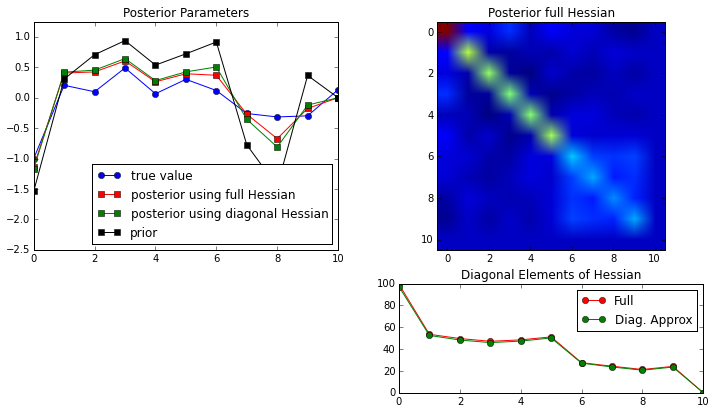

In [4]:
# Take a subset of the data just for illustrative purposes
XX = copy.copy(X[0:500,:])
yy = copy.copy(y[0:500])

#----------------------------------------------------------------------------------------
# Fitting using the full prior Hessian. Note that the full posterior Hessian is returned
w_posterior, H_posterior = bl.fit_bayes_logistic(yy, XX, w_prior, H_prior)

print 'Shape of full Hessian', np.shape(H_posterior)

#----------------------------------------------------------------------------------------
# Fitting using a diagonal approximation. Note here we store the diagonal as a vector and do not
# need to supply a full matrix.  Note that only the diagonal of the posterior Hessian is returned.

H_prior_diag = np.diag(H_prior)
w_posterior_diag, H_posterior_diag = bl.fit_bayes_logistic(yy, XX, w_prior, H_prior_diag)

print 'Shape of diagonal Hessian', np.shape(H_posterior_diag)

#----------------------------------------------------------------------------------------
# plot various results

# plot the posterior parameters and compare to the true parameters
plt.figure(figsize = (12,9))
plt.subplot(221)
plt.plot(w_true,'bo-',label = 'true value')
plt.plot(w_posterior,'rs-', label = 'posterior using full Hessian')
plt.plot(w_posterior_diag,'gs-', label = 'posterior using diagonal Hessian')
plt.plot(w_prior,'ks-', label = 'prior')
plt.ylim([-2.5,1.25])
plt.legend(loc = 'lower right')
plt.title('Posterior Parameters')

# plot the posterior Hessian
plt.subplot(222)
plt.imshow(H_posterior)
plt.title('Posterior full Hessian')

# compare the diagonal elements of the full posterior Hessian with the diagonal posterior Hessian
# any differences in fit come from the full Hessian's off diagonal elements
plt.subplot(426)
plt.plot(np.diag(H_posterior),'ro-', label = 'Full')
plt.plot(H_posterior_diag,'go-',label = 'Diag. Approx')
plt.title('Diagonal Elements of Hessian')
plt.legend(loc = 'upper right')

### 2) Moderated Probability

For a given set of fitted parameters, the MAP estimate of the logistic regression probability can be obtained using the function bl.logistic_prob.  However, this only takes into account the MAP estimate of the parameters. We also have information about the uncertainty in the parameters (that is the full distribution, not just the mode) which can give a more accurate estimate of the probability.  The full Bayesian estimate is given with bl.bayes_logistic_prob and requires the Hessian as input.

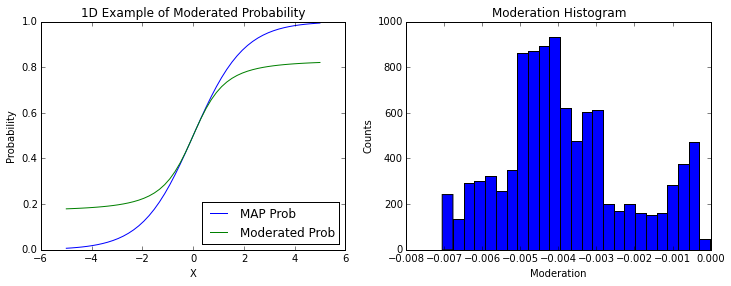

In [6]:
# Do a one dimensional example (a single feature) to demonstrate how the logistic probability
# is moderated when uncertainty (the full distribution / the Hessian) is taken into account

# create the inputs
# note, the inputs need to have dimension !!!
Xlin = np.atleast_2d(np.linspace(-5,5)).T  # X needs to be 2 dimensional
wlin = np.atleast_1d(1.)                   # the prior parameter needs to be one dimensional
Hlin = np.atleast_1d(1.)                   # the prior Hessian needs to be at least one dimensional

#-------------------------------------------------------------------------------------------
# get the logistic and moderated logistic probabilities
prob_lin = bl.logistic_prob(Xlin,wlin)
bayes_prob_lin = bl.bayes_logistic_prob(Xlin,wlin,Hlin)

#-------------------------------------------------------------------------------------------
# plot this example
plt.figure(figsize=(12,9))

plt.subplot(221)
plt.plot(Xlin,prob_lin,label = 'MAP Prob')
plt.plot(Xlin,bayes_prob_lin,label = 'Moderated Prob')
plt.xlabel('X')
plt.ylabel('Probability')
plt.title('1D Example of Moderated Probability')
plt.legend(loc = 'lower right')

#-------------------------------------------------------------------------------------------
# Now calculate the moderated probability from our above sine-wave example using the full Hessian
logistic_prob = bl.logistic_prob(X,w_posterior)
bayes_logistic_prob = bl.bayes_logistic_prob(X,w_posterior,H_posterior)

#-------------------------------------------------------------------------------------------
# plot a histogram, across the whole data set, showing the absolute value of the difference
# between moderated and regular logistic probabilities
plt.subplot(222)
plt.hist(np.abs(bayes_logistic_prob-0.5)- np.abs(logistic_prob-0.5) ,25);
plt.xlabel('Moderation')
plt.ylabel('Counts')
plt.title('Moderation Histogram')




###3) Using different optimizers

There are two other options for optimizers.  BFGS and L-BFGS-B (which allows the imposition of bounds on the parameters)

Neither of these solvers utilize Hessian information for the OPTIMIZATION. However, the prior Hessian is still part of the OBJECTIVE FUNCTION so it still needs to be supplied.  You can use either the full prior Hessian or a diagonal approx.  However, if using BFGS or L-BFGS-B it probably makes more sense to use a diagonal approximation.

Of note, to keep BFGS and L-BFGS-B solvers stable, the gradient vector is (by default) normalized to length 1 before being supplied to scipy.optimize.  (This is not done for the Newton-CG solver.)

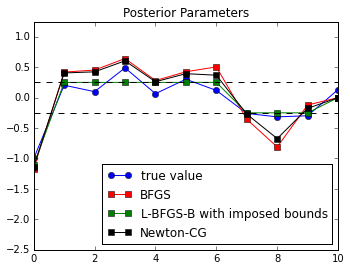

In [7]:
# Fit via BFGS. 
w_posterior_BFGS, H_posterior_BFGS = bl.fit_bayes_logistic(yy, XX, w_prior, H_prior_diag,
                                                           solver = 'BFGS')

#----------------------------------------------------------------------------------------
# fit via L-BFGS-B so we can impose bounds

# first make a list of tuples with the bounds for each parameter in it 
# (see the scipy.optimize.minimize docs)

bnd = (-0.25,0.25)
bnd_list = [(None,None)]
for _ in np.arange(p-1):
    bnd_list.append(bnd)

# Now do the fitting
w_posterior_LBFGSB, H_posterior_LBFGSB = bl.fit_bayes_logistic(yy, XX, w_prior, H_prior_diag,
                                                           solver = 'L-BFGS-B', bounds = bnd_list)

#----------------------------------------------------------------------------------------
# plot the true parameters and the results from various fits. 
plt.figure(figsize = (12,9))
plt.subplot(221)
plt.plot(w_true,'bo-',label = 'true value')
plt.plot(w_posterior_BFGS,'rs-', label = 'BFGS')
plt.plot(w_posterior_LBFGSB,'gs-', label = 'L-BFGS-B with imposed bounds')
plt.plot(w_posterior,'ks-', label = 'Newton-CG')
plt.plot((0, 10), (0.25, 0.25), 'k--')
plt.plot((0, 10), (-0.25, -0.25), 'k--')
plt.ylim([-2.5,1.25])
plt.legend(loc = 'lower right')
plt.title('Posterior Parameters')


### 4) Online Updating

Bayesian Logistic Regression can be used to update a model in real time, as data points come in. While it is generally more stable to do the updating in small batches, we can do the updating a single data point at a time, as we demonstrate here.

To show the reduction in error as we continue to update we will plot the root mean squared error between the fitted and true parameters. We will compare these results with those of batch learning (using sklearn)

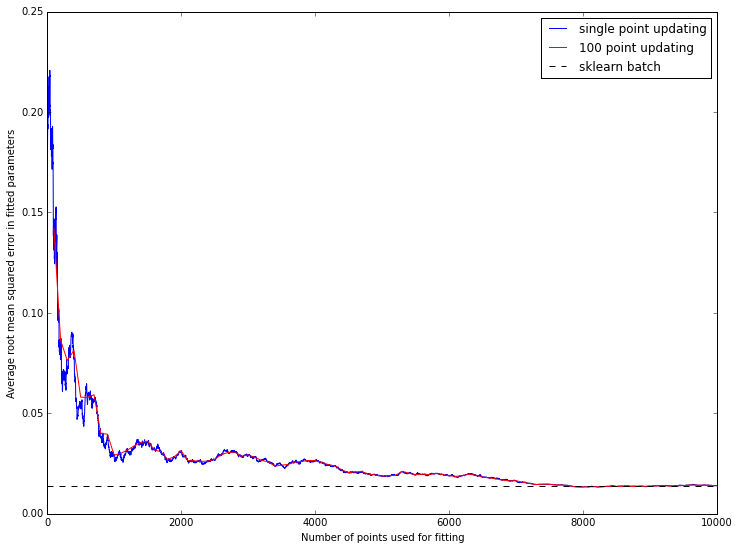

In [8]:
# Update model one data point at a time

rmserror_1 = np.zeros(N,)
t_1 = np.linspace(1,N,N)

w_bayes = copy.copy(w_prior)
H_bayes = copy.copy(H_prior)

for _ in np.arange(N):
    
    # update based upon a single point
    w_bayes, H_bayes = bl.fit_bayes_logistic(y[_:_+1], X[_:_+1,:], w_bayes, H_bayes)
   
    # store the average root mean squared error of the fitted parameter
    rmserror_1[_] = np.sqrt( np.dot(w_bayes - w_true,w_bayes-w_true))/p

#--------------------------------------------------------------------------------------
# Update model 100 data points at a time 

w_bayes = copy.copy(w_prior)
H_bayes = copy.copy(H_prior)  

nstep = 100
niter=N/nstep

rmserror_100 = np.zeros(niter)
t_100 = np.linspace(nstep,N,niter)


for _ in np.arange(niter):
     
    idx  = range(_*nstep, (_+1)*nstep, 1)
    # update based upon 100 points
    w_bayes, H_bayes = bl.fit_bayes_logistic(y[idx], X[idx,:], w_bayes, H_bayes)
   
    # store average the root mean squared error of the fitted parameter
    rmserror_100[_] = np.sqrt( np.dot(w_bayes - w_true,w_bayes-w_true))/p
   
#--------------------------------------------------------------------------------------
# do batch fitting using sklearn for comparison

clf_reg =  linear_model.LogisticRegression(penalty='l2', dual=False, tol=0.0001, C= 100,
                                                      fit_intercept=False, intercept_scaling=1, 
                                                      class_weight=None, random_state=None)
    
clf_reg.fit(X,y)

error_batch =  np.sqrt(np.dot(np.ravel(clf_reg.coef_) - w_true,np.ravel(clf_reg.coef_) - w_true ) )/p

#--------------------------------------------------------------------------------------
# plot the error as a function of the number of data points used for fitting

plt.figure(figsize=(12,9))
plt.plot(t_1[0:N],rmserror_1, 'b', label = 'single point updating')
plt.plot(t_100[0:N],rmserror_100, 'r', label ='100 point updating')
plt.plot((0, N), (error_batch, error_batch), 'k--',label = 'sklearn batch')
plt.legend(loc = 'upper right')
plt.xlabel('Number of points used for fitting')
plt.ylabel('Average root mean squared error in fitted parameters')


### 5) Weighting data points

The code has the capability to individual weight data points (NOT classes as in sklearn) differently.  Instead of using resampling of points, we weight the points directly in the log likelihood.  The log likelihood now has the following form.

$\log \mathcal{L} (w | y, \eta) = \sum_{i=1}^N \eta_i \{ y_i \log p_i + (1-y_i)\log(1 - y_i) \}$

where $\eta_i$ is the weight of data point $i$. 

The weights are specified as an optional 1D weight vector, the same length as the data points.

(4000L, 11L) (4000L,)
(4000L,)


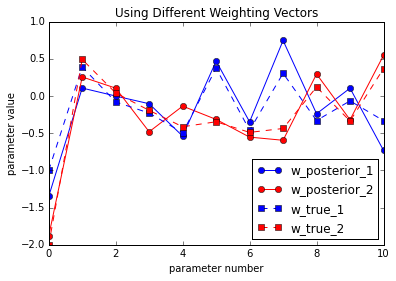

In [9]:
#---------------------------------------------------------------------------------------------
# Make a data set using two different parameter vectors to show the effect of weighting
# half the data will use one parameter vector, half will use another

# Number of data points and variables
M = 2000
p = 11

# make random feature matricies
C1 = np.random.random([M,p])
C2 = np.random.random([M,p])

# make two parameter vectors
w_true_1 = np.random.uniform(-0.5,0.5,p)
w_true_1[0] = -1 # bias parameter
w_true_2 = np.random.uniform(-0.5,0.5,p)
w_true_2[0] = -2 # bias parameter

# use a zero mean prior for illustration
w_prior_weights = np.zeros(p,)
H_prior_weights = 0.1*np.diag(np.ones(p,))

# make some data
mu_1 = bl.logistic_prob(C1,w_true_1)
y1 = np.empty([M])
for _ in np.arange(M):
    y1[_] = np.random.binomial(1,mu_1[_])
    
mu_2 = bl.logistic_prob(C2,w_true_2)
y2 = np.empty([M])
for _ in np.arange(M):
    y2[_] = np.random.binomial(1,mu_2[_])
    
X_weights = copy.copy(np.vstack((C1,C2)))
y_weights = copy.copy(np.hstack((y1,y2)))

print X_weights.shape, y_weights.shape

#---------------------------------------------------------------------------------------------
# make two different weight vectors to see that even if you fit the same data you can get 
# different answers by weighting the data points differently
# (this is a somewhat contrived example to be sure ...)

weights_1 = np.hstack((np.ones(M,),np.zeros(M,)))
weights_2 = np.hstack((np.zeros(M,),np.ones(M,)))
print weights_1.shape

#---------------------------------------------------------------------------------------------
# Now fit the same data using two different weighting vectors

w_posterior_1, H_posterior_1 = bl.fit_bayes_logistic(y_weights, X_weights, 
                                                     w_prior_weights, H_prior_weights, weights = weights_1)

w_posterior_2, H_posterior_2 = bl.fit_bayes_logistic(y_weights, X_weights, 
                                                     w_prior_weights, H_prior_weights, weights = weights_2)

#----------------------------------------------------------------------------------------------
# And plot

plt.plot(w_posterior_1,'bo-', label = 'w_posterior_1')
plt.plot(w_posterior_2, 'ro-', label = 'w_posterior_2')

plt.plot(w_true_1,'bs--', label = 'w_true_1')
plt.plot(w_true_2, 'rs--', label = 'w_true_2')
plt.legend(loc = 'lower right')

plt.title('Using Different Weighting Vectors')
plt.xlabel('parameter number')
plt.ylabel('parameter value')

### 6) Variable selection (sparse models) using p-values

We can calculate p-values on all the fitted parameters using the function get_pvalues.  These can be used for variable selection, similar to what we would do for L1 regularization.

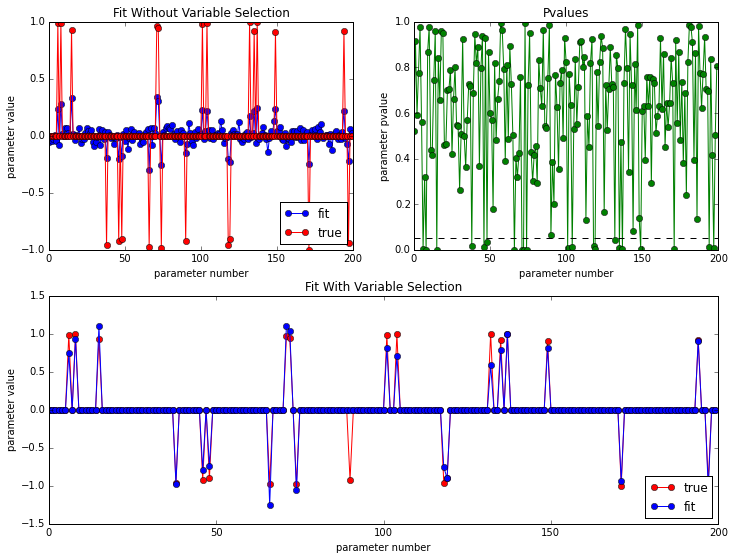

In [10]:
# make a data set with very many parameters, most of which are irrelevant, so its prone to overfitting.

N = 2000
p = 200

# random feature matrix
X_sparse = np.random.random([N,p])

# make sparse parameter vector
w_true_sparse = np.random.uniform(-1.,1,p)
w_true_sparse[np.abs(w_true_sparse)<0.9] = 0

# make some binary responses from this data
mu_sparse = bl.logistic_prob(X_sparse,w_true_sparse)
y_sparse = np.empty([N])
for _ in np.arange(N):
    y_sparse[_] = np.random.binomial(1,mu_sparse[_])
    
# make a zero mean prior (since we are looking for sparsity) 
w_prior_sparse = np.zeros(p,)
# and a diagonal only Hessian because we have many parameters
H_prior_sparse = np.ones(p,)

#------------------------------------------------------------------------------------------------------
# fit
w, H = bl.fit_bayes_logistic(y_sparse, X_sparse, w_prior_sparse, H_prior_sparse)

# plot the fit withouth the variable selection
plt.figure(figsize=(12,9))
plt.subplot(221)
plt.plot(w,'bo-',label = 'fit')
plt.plot(w_true_sparse,'ro-', label = 'true')
plt.xlabel('parameter number')
plt.ylabel('parameter value')
plt.title('Fit Without Variable Selection')
plt.legend(loc = 'lower right')

#------------------------------------------------------------------------------------------------------
# calculate the p-values to do variable selection with
pvals = bl.get_pvalues(w,H)

# plot the p-values
plt.subplot(222)
plt.plot(pvals,'go-')
plt.plot((0, 200),(0.05, 0.05),'k--')
plt.xlabel('parameter number')
plt.ylabel('parameter pvalue')
plt.title('Pvalues')

#------------------------------------------------------------------------------------------------------
# Do variable selection

# get indices of the p-values < some cutoff. Here we use p<0.05
# in general one would want to get this cutoff via cross validation
idx = [i for i in range(len(pvals)) if pvals[i] <=0.05]

# now refit using only those parameters with p-values less than the cutoff
w_short, H_short = bl.fit_bayes_logistic(y_sparse, X_sparse[:,idx], w_prior_sparse[idx], H_prior_sparse[idx])

# fill out the full parameter vector using only those that were selected
w_sparse = np.zeros(p,)
w_sparse[idx] = w_short

# plot the true and fitted (after variable selection) parameters                                         
plt.subplot(212)
plt.plot(w_true_sparse,'ro-',label = 'true')
plt.plot(w_sparse,'bo-', label = 'fit')
plt.xlabel('parameter number')
plt.ylabel('parameter value')
plt.title('Fit With Variable Selection')
plt.legend(loc = 'lower right')